In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)


In [20]:
df = pd.read_csv("Creditcard_data.csv")

print(df.head())
print(df.Class.value_counts())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [21]:
X = df.drop("Class", axis=1)
y = df["Class"]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [23]:
ros = RandomOverSampler(random_state=42)

X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("Balanced TRAIN:\n", pd.Series(y_train_bal).value_counts())
print("\nOriginal TEST:\n", y_test.value_counts())


Balanced TRAIN:
 Class
0    610
1    610
Name: count, dtype: int64

Original TEST:
 Class
0    153
1      2
Name: count, dtype: int64


In [24]:
def simple_random_sample(X, y, frac=0.7):
    idx = X.sample(frac=frac, random_state=42).index
    return X.loc[idx], y.loc[idx]


def stratified_sample(X, y, frac=0.7):
    Xs, _, ys, _ = train_test_split(
        X, y,
        train_size=frac,
        stratify=y,
        random_state=42
    )
    return Xs, ys


def systematic_sample(X, y, k=2):
    idx = np.arange(0, len(X), k)
    return X.iloc[idx], y.iloc[idx]


def bootstrap_sample(X, y):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    return X.iloc[idx], y.iloc[idx]


def cluster_sample(X, y, frac=0.7):
    perm = np.random.permutation(len(X))
    cut = int(len(X) * frac)
    chosen = perm[:cut]
    return X.iloc[chosen], y.iloc[chosen]


In [25]:
models = {
    "M1_RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "M2_KNN": KNeighborsClassifier(),
    "M3_NaiveBayes": GaussianNB(),
    "M4_MLP": MLPClassifier(max_iter=300, random_state=42),
    "M5_SVM": SVC()
}


In [26]:
sampling_methods = {
    "Sampling1_Simple": simple_random_sample,
    "Sampling2_Stratified": stratified_sample,
    "Sampling3_Systematic": systematic_sample,
    "Sampling4_Bootstrap": bootstrap_sample,
    "Sampling5_Cluster": cluster_sample
}


In [27]:
results = pd.DataFrame(index=models.keys(),
                       columns=sampling_methods.keys())

for s_name, sampler in sampling_methods.items():

    X_samp, y_samp = sampler(X_train_bal, y_train_bal)

    for m_name, model in models.items():

        clf = model
        clf.fit(X_samp, y_samp)

        preds = clf.predict(X_test)

        acc = accuracy_score(y_test, preds)

        results.loc[m_name, s_name] = round(acc * 100, 2)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
results = results.astype(float)
results


,Sampling1_Simple,Sampling2_Stratified,Sampling3_Systematic,Sampling4_Bootstrap,Sampling5_Cluster
M1_RandomForest,99.35,99.35,99.35,99.35,99.35
M2_KNN,96.77,96.77,96.77,96.77,96.77
M3_NaiveBayes,96.13,94.19,95.48,94.19,95.48
M4_MLP,97.42,97.42,93.55,97.42,97.42
M5_SVM,72.90,69.03,69.03,50.97,69.03


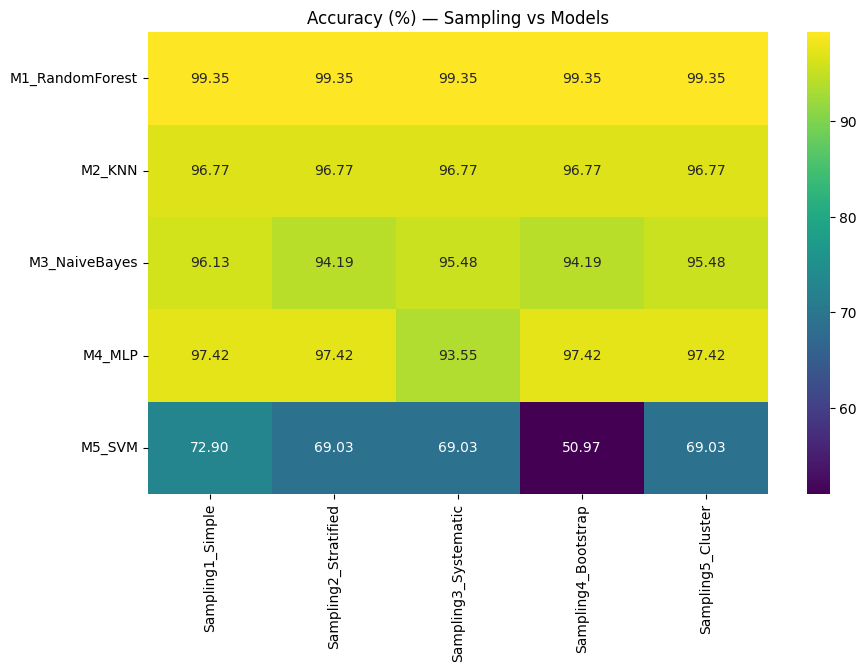

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(results, annot=True, fmt=".2f", cmap="viridis")
plt.title("Accuracy (%) — Sampling vs Models")
plt.show()


In [30]:
print("\nBest sampling for each model:\n")

for model in results.index:
    best_sampling = results.loc[model].idxmax()
    best_score = results.loc[model].max()

    print(f"{model} → {best_sampling} ({best_score}%)")


print("\nBest model for each sampling:\n")

for sampling in results.columns:
    best_model = results[sampling].idxmax()
    best_score = results[sampling].max()

    print(f"{sampling} → {best_model} ({best_score}%)")



Best sampling for each model:

M1_RandomForest → Sampling1_Simple (99.35%)
M2_KNN → Sampling1_Simple (96.77%)
M3_NaiveBayes → Sampling1_Simple (96.13%)
M4_MLP → Sampling1_Simple (97.42%)
M5_SVM → Sampling1_Simple (72.9%)

Best model for each sampling:

Sampling1_Simple → M1_RandomForest (99.35%)
Sampling2_Stratified → M1_RandomForest (99.35%)
Sampling3_Systematic → M1_RandomForest (99.35%)
Sampling4_Bootstrap → M1_RandomForest (99.35%)
Sampling5_Cluster → M1_RandomForest (99.35%)
